In [9]:
# https://drive.google.com/file/d/1f7WAwkuTFgLzCCTs2HZv3AmtBkET4l1M/view?usp=share_link
!gdown --id 1f7WAwkuTFgLzCCTs2HZv3AmtBkET4l1M

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1f7WAwkuTFgLzCCTs2HZv3AmtBkET4l1M
To: /content/sem_eval_2018.zip
100% 662k/662k [00:00<00:00, 133MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!unzip './sem_eval_2018.zip'

Archive:  ./sem_eval_2018.zip
replace sem_eval_2018/val.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## **1. Import the necessary libraries**

In [10]:
!pip install unidecode tensorflow_addons

In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import nltk
import unidecode
import tensorflow_addons as tfa

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

RANDOM_SEED = 1
tf.random.set_seed(RANDOM_SEED)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **2. Data preprocessing**


In [12]:
english_stop_words = stopwords.words('english') # Get the list of stopwords from the nltk library
stemmer = PorterStemmer() # Declare stemmer object (used to stem in normalize text function)

# Build the text normalization function
def text_normalize(text):
    text = text.lower() # Convert letters to lowercase
    text = unidecode.unidecode(text) # Encoded to ASCII
    text = text.strip() # Remove special characters at the beginning and end of the string
    text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
    text = ' '.join([word for word in text.split(' ') if word not in english_stop_words]) # Remove stopwords
    text = ' '.join([stemmer.stem(word) for word in text.split(' ')]) # Stemming

    return text

In [13]:
BATCH_SIZE = 128
MAX_SEQ_LEN = 128
MAX_FEATURES = 5000
EMBEDDING_DIMS = 64

ROOT_FOLDER_PATH = './data'

train_filepath = os.path.join(ROOT_FOLDER_PATH, 'train.csv')
val_filepath = os.path.join(ROOT_FOLDER_PATH, 'val.csv')
test_filepath = os.path.join(ROOT_FOLDER_PATH, 'test.csv')

train_df = pd.read_csv(train_filepath,
                index_col=0)
val_df = pd.read_csv(val_filepath,
                index_col=0)
test_df = pd.read_csv(test_filepath,
                index_col=0)

train_df['Tweet'] = train_df['Tweet'].apply(lambda p: text_normalize(p)).astype(str)
val_df['Tweet'] = val_df['Tweet'].apply(lambda p: text_normalize(p)).astype(str)
test_df['Tweet'] = test_df['Tweet'].apply(lambda p: text_normalize(p)).astype(str)

class_lst = np.array(train_df.columns[2:])
n_classes = len(class_lst)

X_train, y_train = train_df['Tweet'].to_numpy(), train_df[class_lst].astype('int').to_numpy()
X_val, y_val = val_df['Tweet'].to_numpy(), val_df[class_lst].astype('int').to_numpy()
X_test, y_test = test_df['Tweet'].to_numpy(), test_df[class_lst].astype('int').to_numpy()

In [14]:
train_df

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-En-21441,worri payment problem may never joyc meyer m...,False,True,False,False,False,False,True,False,False,False,True
1,2017-En-31535,whatev decid make sure make happi,False,False,False,False,True,True,True,False,False,False,False
2,2017-En-21068,max_kellerman also help major nfl coach inept...,True,False,True,False,True,False,True,False,False,False,False
3,2017-En-31436,accept challeng liter even feel exhilar victor...,False,False,False,False,True,False,True,False,False,False,False
4,2017-En-22195,roommat okay cant spell autocorrect terribl fi...,True,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,2017-En-21383,nicky57672 hi work toward highlight concern ke...,False,False,False,False,False,False,False,False,False,False,False
834,2017-En-41441,andreamitchel said berniesand play hrc campaig...,False,True,False,False,False,False,False,False,False,True,False
835,2017-En-10886,isthataspid dhodg fight guy dont insult lion l...,True,False,True,False,False,False,False,True,False,False,False
836,2017-En-40662,wonder guy broke peni sex seriou,False,False,False,False,False,False,False,False,False,True,False


In [15]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

In [16]:
def inverse_label(class_lst, onehot_label):

    return class_lst[onehot_label > 0]

for text_batch, label_batch in train_ds.take(1):
  for i in range(10):
    print(f"Tweet {i}: ", text_batch.numpy()[i])
    #print("Label:", inverse_label(class_lst, label_batch.numpy()[i]))

Tweet 0:  b'worri payment problem may never  joyc meyer  motiv leadership worri'
Tweet 1:  b'whatev decid make sure make happi'
Tweet 2:  b'max_kellerman  also help major nfl coach inept bill obrien play call wow  gopat'
Tweet 3:  b'accept challeng liter even feel exhilar victori  georg patton'
Tweet 4:  b'roommat okay cant spell autocorrect terribl firstworldprob'
Tweet 5:  b'that cute atsu probabl shi photo cherri help uwu'
Tweet 6:  b'think human sens recogn impend doom'
Tweet 7:  b'rooney fuck untouch isnt fuck dread depay look decentishtonight'
Tweet 8:  b'pretti depress u hit pan ur favourit highlight'
Tweet 9:  b'bossupjae pussi weak heard stfu bitch  got threaten pregnant '


In [17]:
# Configure optimal parameters for reading data
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## **3. Build the model**

In [18]:
# Declare the vectorization text layer
text_vectorization_layer = tf.keras.layers.TextVectorization(
    max_tokens=MAX_FEATURES, # Vocabulary size
    output_mode='int', # The token value is the index of the word in vocab
    output_sequence_length=MAX_SEQ_LEN # Maximum number of tokens in 1 vector
)

train_text = train_ds.map(lambda text, labels: text) # Call `content` of all data samples in the training set
text_vectorization_layer.adapt(train_text) # Build vectorization layer based on training data

In [19]:
# Build the model initialization function
def build_model(max_features, max_seq_len, embedding_dims, n_classes):
    model = tf.keras.Sequential([
        # Input layer (receives a string)
        tf.keras.Input(shape=(1,), dtype='string', name='input_layer'),

        # Text Vectorization Layer declared above
        text_vectorization_layer,

        # Embedding Layer (convert tokens into vectors)
        tf.keras.layers.Embedding(input_dim=max_features+1,
                                  output_dim=embedding_dims,
                                  embeddings_initializer=tf.random_uniform_initializer(seed=RANDOM_SEED),
                                  mask_zero=True,
                                  name='embedding_layer'),

        # Bi-LSTM Layer 1
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,
                                    return_sequences=True,
                                    kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED)),
                                    name='bilstm_layer_1'),

        # Bi-LSTM Layer 2
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,
                                    return_sequences=True,
                                    kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED)),
                                    name='bilstm_layer_2'),

        # Bi-LSTM Layer 3
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,
                                    return_sequences=False,
                                    kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED)),
                                    name='bilstm_layer_3'),

        # Dropout Layer 1
        tf.keras.layers.Dropout(0.2),

        # Fully-connected Layer 1
        tf.keras.layers.Dense(64,
                              activation='relu',
                              kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED),
                              name='fl_layer_1'),

        tf.keras.layers.Dropout(0.3),

        # Fully-connected Layer 2
        tf.keras.layers.Dense(32,
                              activation='relu',
                              kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED),
                              name='fl_layer_2'),

        # Dropout Layer 2
        tf.keras.layers.Dropout(0.3),

        # Output Layer
        tf.keras.layers.Dense(n_classes,
                              activation='sigmoid',
                              kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED),
                              name='output_layer')
    ],
    name='bilstm_model')

    return model

In [20]:
model = build_model(max_features=MAX_FEATURES,
                    max_seq_len=MAX_SEQ_LEN,
                    embedding_dims=EMBEDDING_DIMS,
                    n_classes=n_classes)
model.summary()

Model: "bilstm_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 128)               0         
 ctorization)                                                    
                                                                 
 embedding_layer (Embedding  (None, 128, 64)           320064    
 )                                                               
                                                                 
 bilstm_layer_1 (Bidirectio  (None, 128, 128)          66048     
 nal)                                                            
                                                                 
 bilstm_layer_2 (Bidirectio  (None, 128, 128)          98816     
 nal)                                                            
                                                                 
 bilstm_layer_3 (Bidirectio  (None, 128)              

## **4. Model configuration**

In [21]:
# Declare hyperparameters
EPOCHS = 10

step = tf.Variable(0, trainable=False)
schedule = tf.optimizers.schedules.PiecewiseConstantDecay(
    [10000, 15000], [1e-1, 1e-2, 1e-3])

lr = 1e-2 * schedule(step)
wd = lambda: 1e-5 * schedule(step)

In [22]:
# Model compile
model.compile(
    optimizer=tfa.optimizers.AdamW(weight_decay=wd,
                                   learning_rate=lr), # Use optimizer AdamW
    loss=tf.keras.losses.BinaryCrossentropy(), # Use the BinaryCrossEntropy loss function
    metrics=['accuracy'] # Use Accuracy metric
)

In [23]:
model.summary()

Model: "bilstm_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 128)               0         
 ctorization)                                                    
                                                                 
 embedding_layer (Embedding  (None, 128, 64)           320064    
 )                                                               
                                                                 
 bilstm_layer_1 (Bidirectio  (None, 128, 128)          66048     
 nal)                                                            
                                                                 
 bilstm_layer_2 (Bidirectio  (None, 128, 128)          98816     
 nal)                                                            
                                                                 
 bilstm_layer_3 (Bidirectio  (None, 128)              

## **5. Training**

In [24]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/10
54/54 [==============================] - 40s 204ms/step - loss: 0.5971 - accuracy: 0.0698 - val_loss: 0.5183 - val_accuracy: 0.0621
Epoch 2/10
54/54 [==============================] - 2s 45ms/step - loss: 0.5088 - accuracy: 0.1901 - val_loss: 0.4691 - val_accuracy: 0.2720
Epoch 3/10
54/54 [==============================] - 4s 66ms/step - loss: 0.4447 - accuracy: 0.3377 - val_loss: 0.4046 - val_accuracy: 0.3318
Epoch 4/10
54/54 [==============================] - 3s 49ms/step - loss: 0.3905 - accuracy: 0.3748 - val_loss: 0.3955 - val_accuracy: 0.4797
Epoch 5/10
54/54 [==============================] - 2s 38ms/step - loss: 0.3605 - accuracy: 0.4073 - val_loss: 0.4034 - val_accuracy: 0.4989
Epoch 6/10
54/54 [==============================] - 2s 39ms/step - loss: 0.3425 - accuracy: 0.4203 - val_loss: 0.4013 - val_accuracy: 0.4966
Epoch 7/10
54/54 [==============================] - 4s 67ms/step - loss: 0.3274 - accuracy: 0.4677 - val_loss: 0.4005 - val_accuracy: 0.5045
Epoch 8/10


## **6. Evaluation and visualization**

In [31]:
test_evaluation = model.evaluate(test_ds)

26/26 [==============================] - 0s 18ms/step - loss: 0.4219 - accuracy: 0.5026


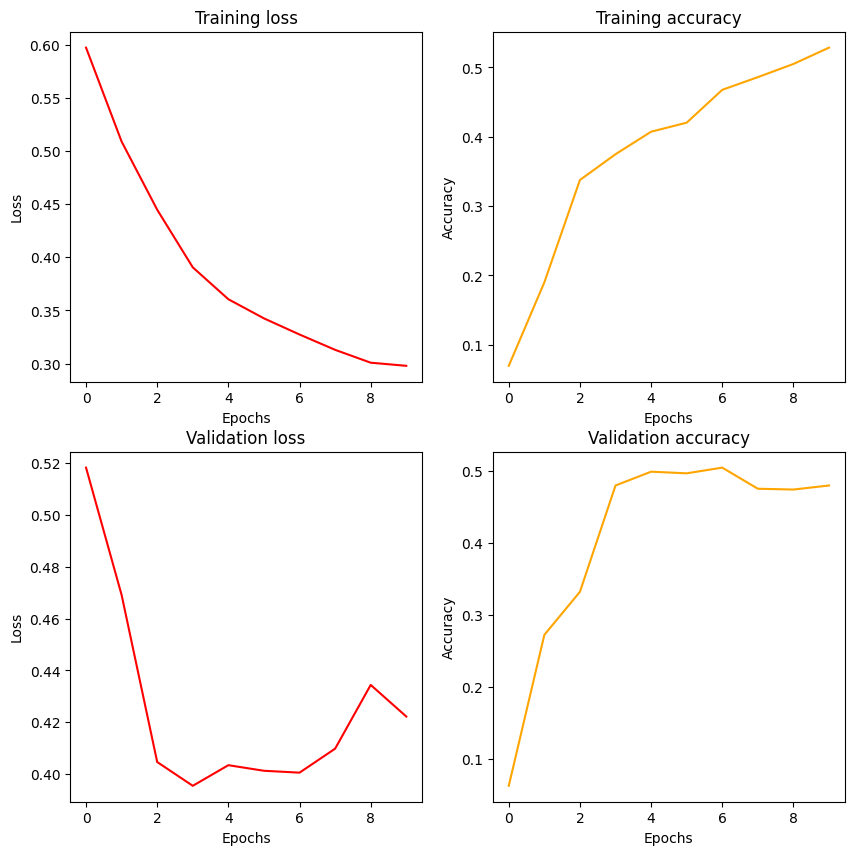

In [32]:
train_loss, train_acc = history.history['loss'], history.history['accuracy']
val_loss, val_acc = history.history['val_loss'], history.history['val_accuracy']

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss')
plt.plot(train_loss, color='red')

plt.subplot(2, 2, 2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy')
plt.plot(train_acc, color='orange')

plt.subplot(2, 2, 3)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation loss')
plt.plot(val_loss, color='red')

plt.subplot(2, 2, 4)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation accuracy')
plt.plot(val_acc, color='orange')

plt.show()

## **7. Inference**

In [33]:
threshold = 0.4

for text_batch, label_batch in test_ds.take(1):
    for i in range(10):
        input_text = text_batch[i].numpy()
        label = label_batch[i].numpy()
        pred = model.predict(np.expand_dims(input_text, 0), verbose=0)[0]
        threshold_pred = np.where(pred > threshold, 1, 0)
        print(f"Text: {input_text}")
        print(f"Label: {inverse_label(class_lst, label)}")
        print(f"Predicted Label(s): ({inverse_label(class_lst, threshold_pred)})")
        print(" ")

Text: b'adnan__786__ asyounotwish dont worri indian armi way dispatch terrorist hell'
Label: ['anger' 'anticipation' 'optimism' 'trust']
Predicted Label(s): (['anger' 'disgust' 'fear' 'pessimism' 'sadness'])
 
Text: b'academi scienc eschew normal sober tone scientif paper call massiv loss wildlif biolog annihil'
Label: ['disgust']
Predicted Label(s): (['joy'])
 
Text: b'blew opportun __ mad'
Label: ['anger' 'disgust' 'sadness']
Predicted Label(s): (['anticipation' 'joy' 'optimism' 'sadness'])
 
Text: b'time 2 week 30'
Label: ['joy' 'sadness']
Predicted Label(s): (['sadness'])
 
Text: b'deppress real partner w depress peopl truli dont understand depth affect us add anxieti ampmak wors'
Label: ['fear' 'sadness']
Predicted Label(s): (['fear' 'sadness'])
 
Text: b'politicoeurop interest choic word confirm govern fund terror bit open door still'
Label: ['anger' 'disgust' 'fear' 'pessimism']
Predicted Label(s): ([])
 
Text: b'ananavarro cnn sure'
Label: ['joy' 'optimism']
Predicted Label(s):